<a href="https://colab.research.google.com/github/leoyu0607/NTUE_Garbage_Classification/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

掛接google drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Start by importing the libraries

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

see the classes present in the dataset

In [ ]:
data_dir = '/content/drive/MyDrive/NTUE 國北教大/專題/dataset/DataSet_v2.1'

classes = os.listdir(data_dir)
print(classes)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'shoes', 'paper', 'plastic_bag', 'trash', 'paper_container', 'metal', 'plastic']


apply transformations to the dataset and import it for use

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

dataset = ImageFolder(data_dir,transform = transformations)

create a helper function to see the image and its corresponding label

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img,label):
  print("label:",dataset.classes[label],"Class No:"+ str(label) + ")")
  plt.imshow(img.permute(1,2,0))

label: battery Class No:0)


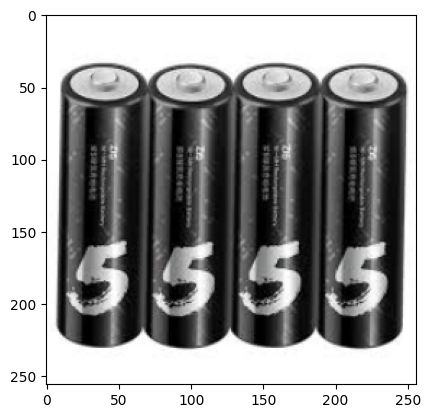

In [ ]:
img,label = dataset[12]
show_sample(img,label)

Loading and Splitting Data

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
len(dataset)

35121

split the dataset into training,validation and test sets

In [ ]:
num_train = int(len(dataset)*0.8)
num_val = int((len(dataset)-num_train)*0.5)
num_test = int(len(dataset)-num_train-num_val)

print(num_train)
print(num_val)
print(num_test)
print(num_train+num_val+num_test)

28096
3512
3513
35121


In [ ]:
train_ds,val_ds,test_ds = random_split(dataset,[num_train,num_val,num_test])
len(train_ds),len(val_ds),len(test_ds)

(28096, 3512, 3513)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

create training and validation dataloaders using `DataLoader`

In [ ]:
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 2,pin_memory = True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers = 2,pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

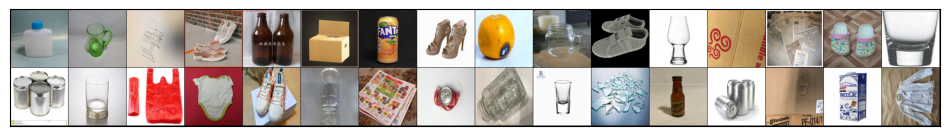

In [ ]:
show_batch(train_dl)

## Model Base

create the model base

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)          # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)            # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)       # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

 using ResNet50 for classifying images

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

In [ ]:
class DenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet121(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = DenseNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 95.4MB/s]


## Porting to GPU

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

DenseNet(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

## Training the Model

the function for fitting the model.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(DenseNet(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.5059919357299805, 'val_acc': 0.06465097516775131}

start training the model:

num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: train_loss: 1.7777, val_loss: 1.6588, val_acc: 0.9659


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2: train_loss: 1.6558, val_loss: 1.6429, val_acc: 0.9801


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3: train_loss: 1.6422, val_loss: 1.6399, val_acc: 0.9776


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4: train_loss: 1.6361, val_loss: 1.6371, val_acc: 0.9801


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5: train_loss: 1.6344, val_loss: 1.6351, val_acc: 0.9821


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6: train_loss: 1.6323, val_loss: 1.6381, val_acc: 0.9798


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7: train_loss: 1.6327, val_loss: 1.6344, val_acc: 0.9830


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8: train_loss: 1.6309, val_loss: 1.6328, val_acc: 0.9841


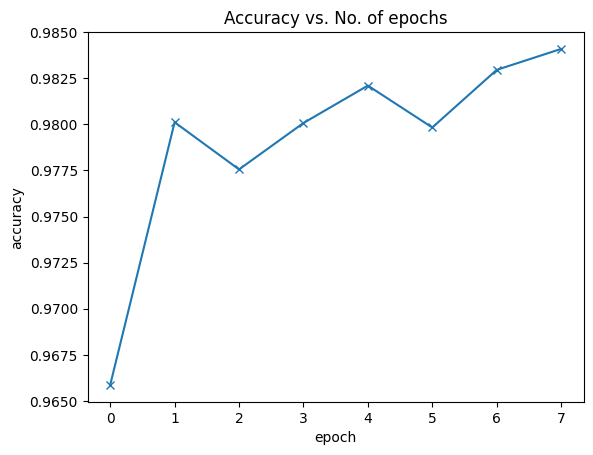

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

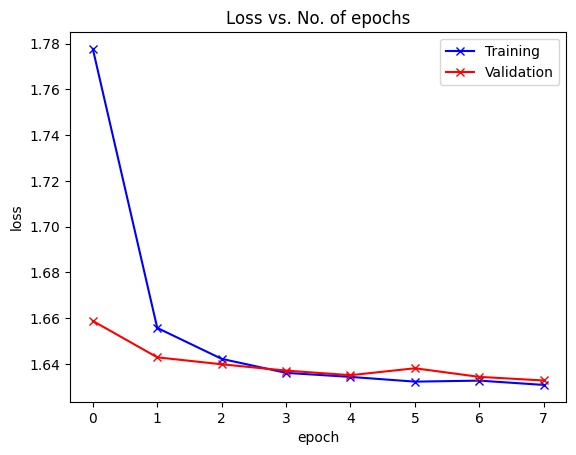

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Visualizing Predictions

In [ ]:
def predict_image(img,model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0),device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  prob,preds = torch.max(yb,dim = 1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

see the model's predictions on the test dataset

Label: biological ,Predicied: biological


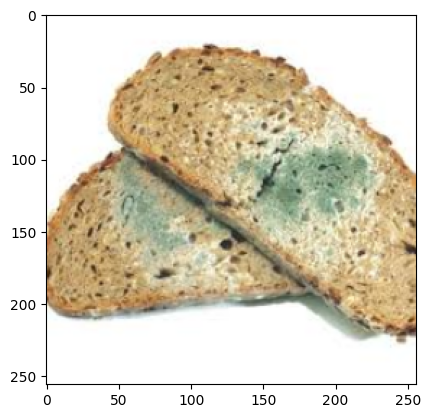

In [ ]:
img,label = test_ds[10]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],',Predicied:',predict_image(img,model))

Label: plastic ,Predicted: plastic


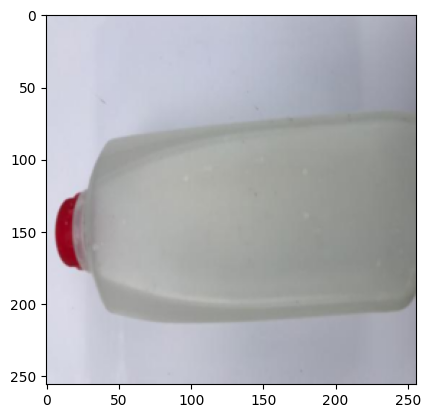

In [ ]:
img,label = test_ds[69]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],',Predicted:',predict_image(img,model))

Label: battery ,Predicted: battery


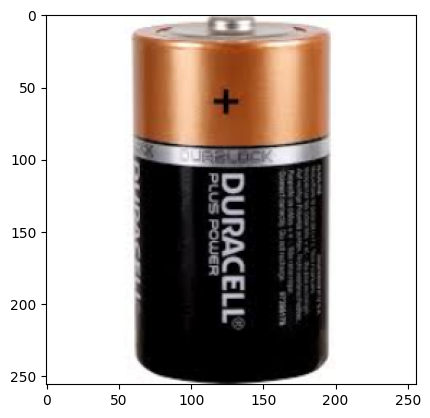

In [ ]:
img,label = test_ds[50]
plt.imshow(img.permute(1,2,0))
print('Label:',dataset.classes[label],',Predicted:',predict_image(img,model))

## Save model

In [ ]:
torch.save(model,'model_v2.1.pt')

## Predicting External Images

1.   清單項目
2.   清單項目



In [ ]:
loaded_model = model

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
  image = Image.open(Path('./'+image_name))

  example_image = transformations(image)
  plt.imshow(example_image.permute(1,2,0))
  print("The image resembles",predict_image(example_image,loaded_model)+".")